## 3.4.2 비음수 행렬 분해(NMF)

- NMF(non-negative matrix factorization)는 유용한 특성을 뽑아내기 위한 또 다른 비지도 학습 알고리즘입니다.
- PCA처럼 어떤 성분의 가중치 합으로 각 데이터 포인트를 나타낼 수 있습니다.
- 하지만 PCA에서는 데이터의 분산이 가장 크고 수직인 성분을 찾았다면 NMF에서는 음수가 아닌 성분과 계수 값을 찾습니다.
- 음수로 된 성분이나 계수가 만드는 상쇄 효과를 이해하기 어려운 PCA보다 대체로 NMF의 주성분이 해석하기 쉽습니다.

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import matplotlib
import graphviz

matplotlib.rcParams['axes.unicode_minus'] = False
path = 'c:/Windows/Fonts/malgun.ttf'
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

### 인위적 데이터에 NMF 적용하기

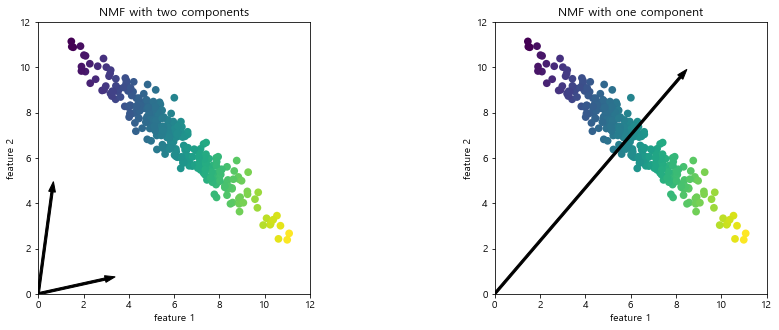

In [2]:
mglearn.plots.plot_nmf_illustration()

-> NMF로 찾은 성분이 2개일 때(왼쪽)와 1개일 때(오른쪽)

### 얼굴 이미지에 NMF 적용하기

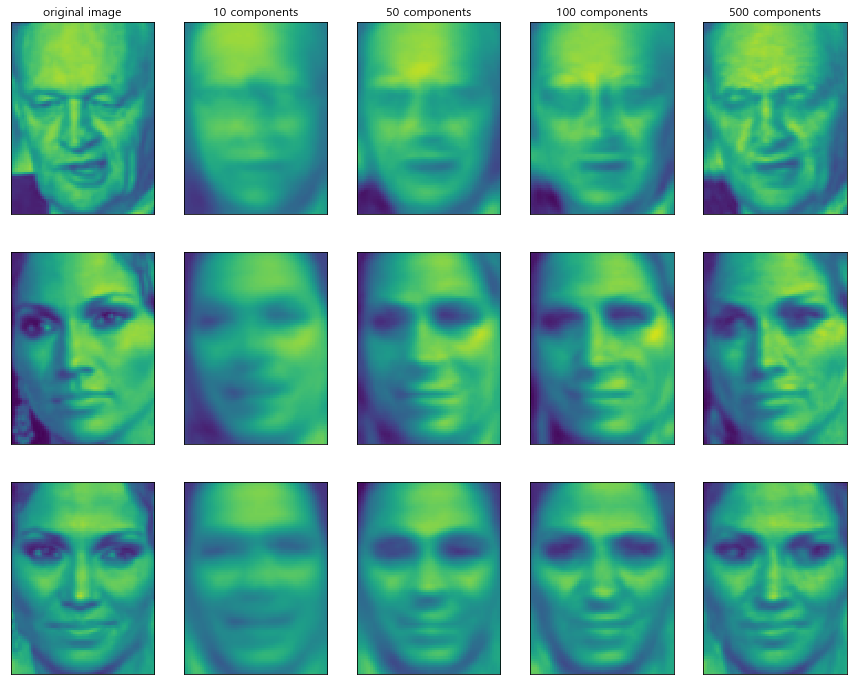

In [3]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]
X_people = X_people / 255.

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

-> NMF 성분 개수에 따른 얼굴 이미지의 재구성

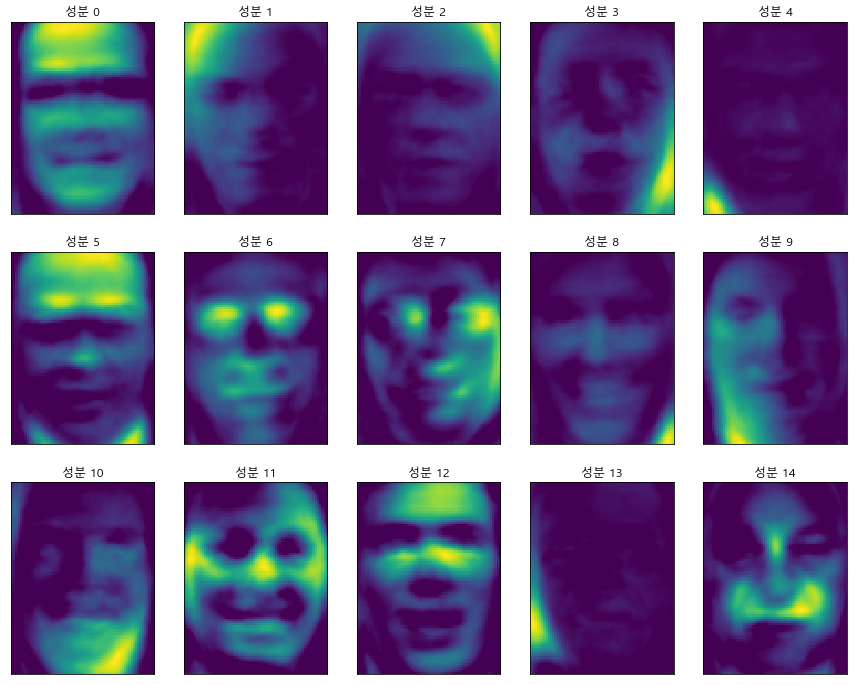

In [4]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15,12),
                        subplot_kw={'xticks': (), 'yticks':()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("성분 {}".format(i))

-> 얼굴 데이터셋에서 NMF로 찾은 성분 15개

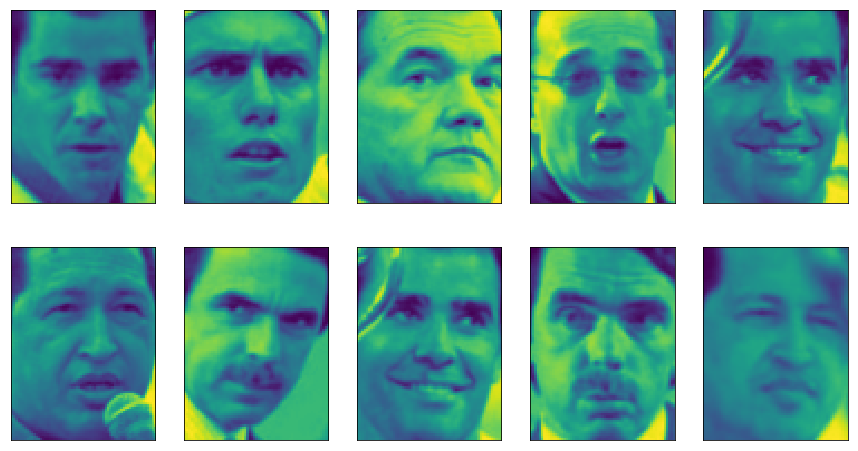

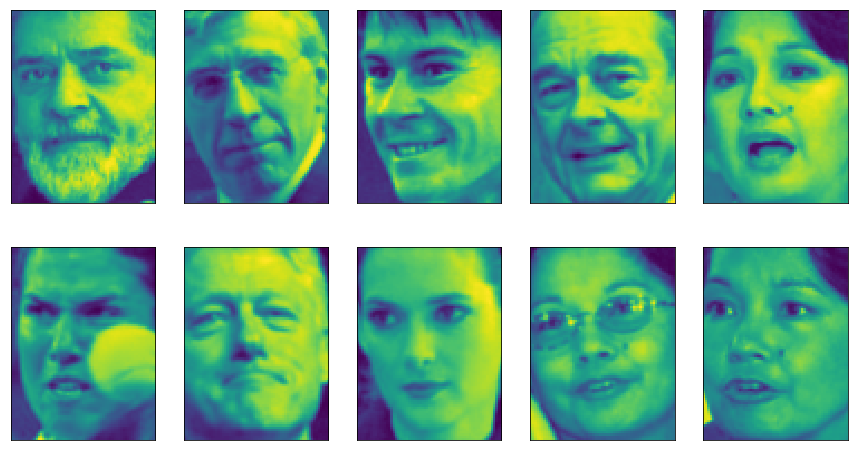

In [5]:
compn = 3
# 4번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다.
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                        subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
    
compn = 7
# 8번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다.
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

-> 성분 3(앞 10명), 성분 7(뒤 10명)의 계수가 큰 얼굴들

Text(0,0.5,'신호')

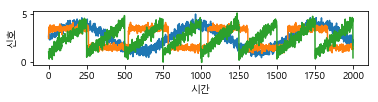

In [6]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("시간")
plt.ylabel("신호")

In [7]:
# 원본 데이터를 사용해 100개의 측정 데이터를 만듭니다.
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("측정 데이터 형태: {}".format(X.shape))

측정 데이터 형태: (2000, 100)


In [8]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("복원한 신호 데이터 형태: {}".format(S_.shape))

복원한 신호 데이터 형태: (2000, 3)


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)

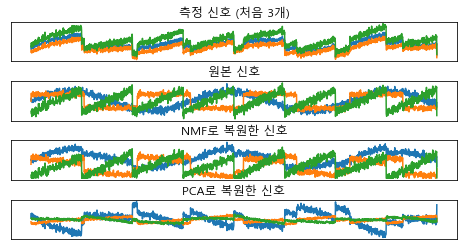

In [10]:
models = [X, S, S_, H]
names = ['측정 신호 (처음 3개)', '원본 신호', 'NMF로 복원한 신호', 'PCA로 복원한 신호']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

-> NMF와 PCA를 사용해 복원한 신호

- 그래프에서 볼 수 있듯이 NMF는 원본 신호를 잘 복원했지만 PCA는 실패했고 데이터 변동의 대부분을 첫 번째 성분을 사용해 나타냈습니다.

## 3.4.3 t-SNE를 이용한 매니폴드 학습

- 매니폴드 학습(manifold learning) 알고리즘이라고 하는 시각화 알고리즘들은 훨씬 복잡한 매핑을 만들어 더 나은 시각화를 제공하고 그 중 특히 t-SNE 알고리즘을 아주 많이 사용합니다.
- t-SNE를 포함해서 일부 매니폴드 알고리즘들은 훈련 데이터를 새로운 표현으로 변환시키지만 새로운 데이터에는 적용하지 못합니다.
- 즉 테스트 세트에는 적용할 수 없고, 단지 훈련했던 데이터만 변환할 수 있습니다.
- 그래서 매니폴드 학습은 탐색적 데이터 분석에 유용하지만 지도 학습용으로는 거의 사용하지 않습니다.
- t-SNE는 이웃 데이터 포인트에 대한 정보를 보존하려 노력합니다.

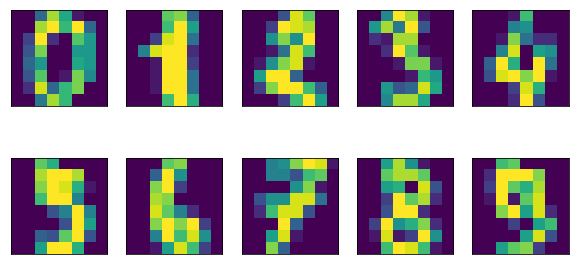

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':(), 'yticks':()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

-> 숫자 데이터셋의 샘플 이미지

Text(0,0.5,'두 번째 주성분')

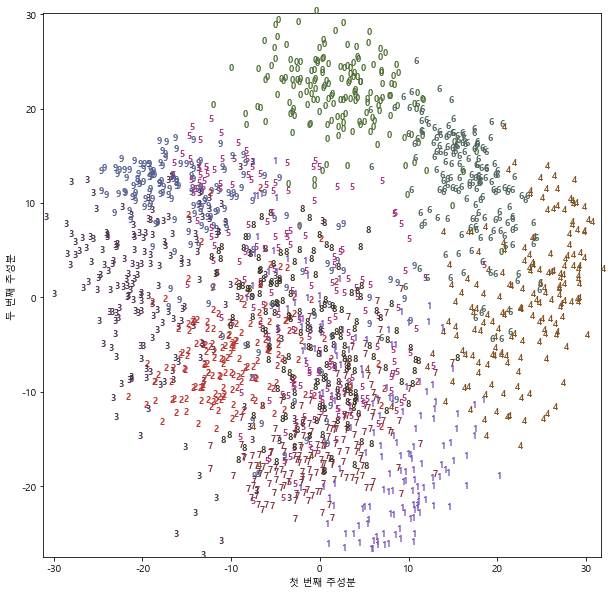

In [12]:
# PCA 모델을 생성합니다.
pca = PCA(n_components=2)
pca.fit(digits.data)
# 처음 두 개의 주성분으로 숫자 데이터를 변환합니다. 
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())

for i in range(len(digits.data)):
    # 숫자 텍스트를 이용해 산점도를 그립니다.
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]], 
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("첫 번째 주성분")
plt.ylabel("두 번째 주성분")

-> 처음 두 개의 주성분을 사용한 숫자 데이터셋의 산점도

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용합니다.
digits_tsne = tsne.fit_transform(digits.data)

Text(0.5,0,'t-SNE 특성 1')

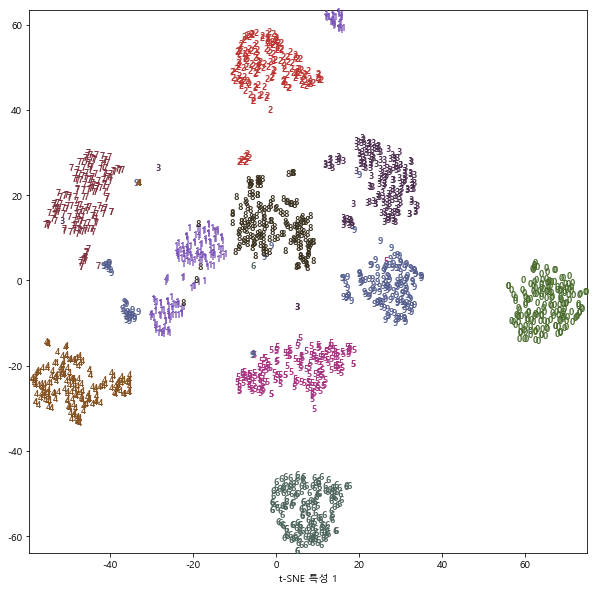

In [14]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # 숫자 텍스트를 이용해 산점도를 그립니다.
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
            color = colors[digits.target[i]],
            fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE 특성 0")
plt.xlabel("t-SNE 특성 1")

-> t-SNE로 찾은 두 개의 성분을 사용한 숫자 데이터셋의 산점도

- t-SNE의 결과는 PCA 모델보다 모든 클래스가 확실히 잘 구분되었습니다.
- 이 알고리즘은 클래스 레이블 정보를 사용하지 않으므로 완전한 비지도 학습입니다.
- 그럼에도 원본 데이터 공간에서 포인트들이 얼마나 가까이 있는지에 대한 정보로 클래스가 잘 구분되는 2차원 표현을 갖습니다.